In [1]:
import os

from tqdm import tqdm
import time

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

In [7]:
data = pd.read_csv("../data/AAPL_dataset_copied.csv")
data.head()

,i,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [ ]:
target = 'target'
prediction_length = 24
id_column = 'item_id'
timestamp_column = 'timestamp'
timeseries_id = 'AAPL'

data = pd.read_csv("../data/AAPL_dataset_copied.csv").drop(['i'], axis=1)
data = data.rename(columns={'close': target, 'symbol': id_column, 'date': timestamp_column})

data[timestamp_column] = pd.to_datetime(data[timestamp_column].str.slice(0, 19))
data = data.sort_values(by=[timestamp_column])

# reindex into business days
date_index = pd.date_range(
    start=data[timestamp_column].min(),
    end=data[timestamp_column].max(),
    freq="B"
)

# reindex and restore timestamp
data = data.set_index(timestamp_column).reindex(date_index)
data.index.name = timestamp_column
data = data.reset_index()


data[id_column] = timeseries_id



# Rebuild context and future parts
context_df = data.iloc[: -prediction_length]
test_df = data.iloc[-prediction_length:]
future_df = test_df.drop(columns=[target])


print("Full dataframe shape: ", data.shape)

print("Input dataframe shape: ", context_df.shape)
display(context_df.head())

print("Test dataframe shape: ", test_df.shape)
display(test_df.head())

print("Future dataframe shape: ", future_df.shape)
display(future_df.head())

print(data.columns)


Full dataframe shape:  (1303, 14)
Input dataframe shape:  (1279, 14)


,timestamp,item_id,target,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2015-05-27,AAPL,132.045,132.260,130.05,130.34,45833246.0,121.682558,121.880685,119.844118,120.111360,45833246.0,0.0,1.0
1,2015-05-28,AAPL,131.780,131.950,131.10,131.86,30733309.0,121.438354,121.595013,120.811718,121.512076,30733309.0,0.0,1.0
2,2015-05-29,AAPL,130.280,131.450,129.90,131.23,50884452.0,120.056069,121.134251,119.705890,120.931516,50884452.0,0.0,1.0
3,2015-06-01,AAPL,130.535,131.390,130.05,131.20,32112797.0,120.291057,121.078960,119.844118,120.903870,32112797.0,0.0,1.0
4,2015-06-02,AAPL,129.960,130.655,129.32,129.86,33667627.0,119.761181,120.401640,119.171406,119.669029,33667627.0,0.0,1.0


Test dataframe shape:  (24, 14)


,timestamp,item_id,target,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1279,2020-04-21,AAPL,268.37,277.25,265.43,276.28,45247893.0,267.662287,276.518870,264.730040,275.551428,45247893.0,0.0,1.0
1280,2020-04-22,AAPL,276.10,277.90,272.20,273.61,29264342.0,275.371902,277.167155,271.482187,272.888469,29264342.0,0.0,1.0
1281,2020-04-23,AAPL,275.03,281.75,274.87,275.87,31203582.0,274.304724,281.007003,274.145146,275.142509,31203582.0,0.0,1.0
1282,2020-04-24,AAPL,282.97,283.01,277.00,277.20,31627183.0,282.223785,282.263680,276.269529,276.469001,31627183.0,0.0,1.0
1283,2020-04-27,AAPL,283.17,284.54,279.95,281.80,29271893.0,282.423258,283.789645,279.211749,281.056871,29271893.0,0.0,1.0


Future dataframe shape:  (24, 13)


,timestamp,item_id,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1279,2020-04-21,AAPL,277.25,265.43,276.28,45247893.0,267.662287,276.518870,264.730040,275.551428,45247893.0,0.0,1.0
1280,2020-04-22,AAPL,277.90,272.20,273.61,29264342.0,275.371902,277.167155,271.482187,272.888469,29264342.0,0.0,1.0
1281,2020-04-23,AAPL,281.75,274.87,275.87,31203582.0,274.304724,281.007003,274.145146,275.142509,31203582.0,0.0,1.0
1282,2020-04-24,AAPL,283.01,277.00,277.20,31627183.0,282.223785,282.263680,276.269529,276.469001,31627183.0,0.0,1.0
1283,2020-04-27,AAPL,284.54,279.95,281.80,29271893.0,282.423258,283.789645,279.211749,281.056871,29271893.0,0.0,1.0


Index(['timestamp', 'item_id', 'target', 'high', 'low', 'open', 'volume',
       'adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume', 'divCash',
       'splitFactor'],
      dtype='object')


In [4]:
pred_df = pipeline.predict_df(
    context_df,
    future_df = future_df,
    prediction_length = prediction_length,
    quantile_levels = [0.1, 0.5, 0.9],
    id_column = id_column,
    timestamp_column = timestamp_column,
    target = target,
    #batch_size = 256,
    #inputs = { "past_time_features": True, "future_time_features": True },
)

pred_df.head(10)

,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,AAPL,2020-04-21,target,275.477295,270.720612,275.477295,280.366089
1,AAPL,2020-04-22,target,276.931702,272.440826,276.931702,281.187408
2,AAPL,2020-04-23,target,278.092499,273.385193,278.092499,281.573730
3,AAPL,2020-04-24,target,281.044739,276.368561,281.044739,285.115936
4,AAPL,2020-04-27,target,282.788696,278.328796,282.788696,287.056854
5,AAPL,2020-04-28,target,282.556091,278.031952,282.556091,287.627869
6,AAPL,2020-04-29,target,285.017883,280.660400,285.017883,290.241974
7,AAPL,2020-04-30,target,288.898987,283.564697,288.898987,293.711792
8,AAPL,2020-05-01,target,289.481262,284.093445,289.481262,294.335022
9,AAPL,2020-05-04,target,291.372009,286.532654,291.372009,296.411377


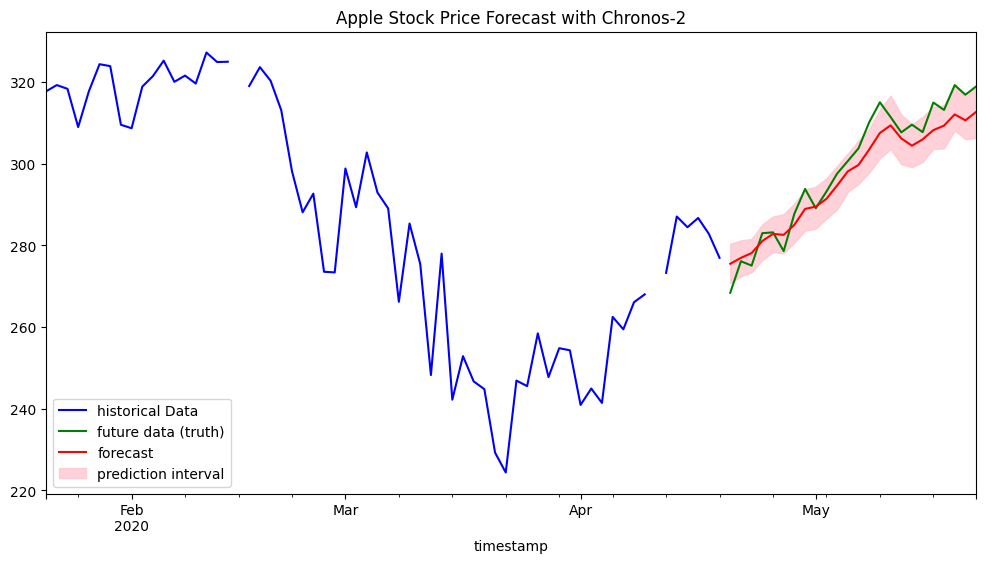

In [12]:
import matplotlib.pyplot as plt

ts_context = context_df.set_index("timestamp")["target"].tail(64)
ts_pred = pred_df.set_index("timestamp")
ts_gound_truth = test_df.set_index("timestamp")["target"]

ts_context.plot(label="historical Data", color="blue", figsize=(12, 6))
ts_gound_truth.plot(label="future data (truth)", color="green")
ts_pred["predictions"].plot(label="forecast", color ="red")

plt.fill_between(
    ts_pred.index,
    ts_pred["0.1"],
    ts_pred["0.9"],
    color="pink",
    alpha=0.7,
    label="prediction interval",
)
plt.legend()
plt.title("Apple Stock Price Forecast with Chronos-2")
plt.show()